# Working with Time Series

Pandas was originally developed in the context of financial modeling, so as you might expect, it contains an extensive set of tools for working with dates, times, and time-indexed data.
Date and time data comes in a few flavors, which we will discuss here:

- *Timestamps* reference particular moments in time (e.g., July 4th, 2021 at 7:00 a.m.).
- *Time intervals* and *periods* reference a length of time between a particular beginning and end point; for example, the month of June 2021. Periods usually reference a special case of time intervals in which each interval is of uniform length and does not overlap (e.g., 24-hour-long periods comprising days).
- *Time deltas* or *durations* reference an exact length of time (e.g., a duration of 22.56 seconds).

This chapter will introduce how to work with each of these types of date/time data in Pandas.
This is by no means a complete guide to the time series tools available in Python or Pandas, but instead is intended as a broad overview of how you as a user should approach working with time series.
We will start with a brief discussion of tools for dealing with dates and times in Python, before moving more specifically to a discussion of the tools provided by Pandas.
After listing some resources that go into more depth, we will review some short examples of working with time series data in Pandas.

## Dates and Times in Python

The Python world has a number of available representations of dates, times, deltas, and time spans.
While the time series tools provided by Pandas tend to be the most useful for data science applications, it is helpful to see their relationship to other tools used in Python.

### Native Python Dates and Times: datetime and dateutil

Python's basic objects for working with dates and times reside in the built-in `datetime` module.
Along with the third-party `dateutil` module, you can use this to quickly perform a host of useful functionalities on dates and times.
For example, you can manually build a date using the `datetime` type:

In [2]:
from datetime import datetime
datetime(year=2021, month=7, day=4)

datetime.datetime(2021, 7, 4, 0, 0)

Or, using the `dateutil` module, you can parse dates from a variety of string formats:

In [3]:
from dateutil import parser
date = parser.parse("4th of July, 2021")
date

datetime.datetime(2021, 7, 4, 0, 0)

Once you have a `datetime` object, you can do things like printing the day of the week:

In [4]:
date.strftime('%A')

'Sunday'

Here we've used one of the standard string format codes for printing dates (`'%A'`), which you can read about in the [`strftime` section](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) of Python's [`datetime` documentation](https://docs.python.org/3/library/datetime.html).
Documentation of other useful date utilities can be found in [``dateutil``'s online documentation](http://labix.org/python-dateutil).
A related package to be aware of is [`pytz`](http://pytz.sourceforge.net/), which contains tools for working with the most migraine-inducing element of time series data: time zones.

The power of `datetime` and `dateutil` lies in their flexibility and easy syntax: you can use these objects and their built-in methods to easily perform nearly any operation you might be interested in.
Where they break down is when you wish to work with large arrays of dates and times:
just as lists of Python numerical variables are suboptimal compared to NumPy-style typed numerical arrays, lists of Python `datetime` objects are suboptimal compared to typed arrays of encoded dates.

### Typed Arrays of Times: NumPy's datetime64

NumPy's `datetime64` dtype encodes dates as 64-bit integers, and thus allows arrays of dates to be represented compactly and operated on in an efficient manner.
The `datetime64` requires a specific input format:

In [5]:
import numpy as np
date = np.array('2021-07-04', dtype=np.datetime64)
date

array('2021-07-04', dtype='datetime64[D]')

Once we have dates in this form, we can quickly do vectorized operations on it:

In [6]:
date + np.arange(12)

array(['2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07',
       '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11',
       '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15'],
      dtype='datetime64[D]')

Because of the uniform type in NumPy `datetime64` arrays, this kind of operation can be accomplished much more quickly than if we were working directly with Python's `datetime` objects, especially as arrays get large
(we introduced this type of vectorization in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb)).

One detail of the `datetime64` and related `timedelta64` objects is that they are built on a *fundamental time unit*.
Because the `datetime64` object is limited to 64-bit precision, the range of encodable times is $2^{64}$ times this fundamental unit.
In other words, `datetime64` imposes a trade-off between *time resolution* and *maximum time span*.

For example, if you want a time resolution of 1 nanosecond, you only have enough information to encode a range of $2^{64}$ nanoseconds, or just under 600 years.
NumPy will infer the desired unit from the input; for example, here is a day-based `datetime`:

In [7]:
np.datetime64('2021-07-04')

np.datetime64('2021-07-04')

Here is a minute-based datetime:

In [8]:
np.datetime64('2021-07-04 12:00')

np.datetime64('2021-07-04T12:00')

You can force any desired fundamental unit using one of many format codes; for example, here we'll force a nanosecond-based time:

In [9]:
np.datetime64('2021-07-04 12:59:59.50', 'ns')

np.datetime64('2021-07-04T12:59:59.500000000')

The following table, drawn from the NumPy `datetime64` documentation, lists the available format codes along with the relative and absolute time spans that they can encode:

|Code  | Meaning     | Time span (relative) | Time span (absolute)   |
|------|-------------|----------------------|------------------------|
| `Y`  | Year        | ± 9.2e18 years       | [9.2e18 BC, 9.2e18 AD] |
| `M`  | Month       | ± 7.6e17 years       | [7.6e17 BC, 7.6e17 AD] |
| `W`  | Week        | ± 1.7e17 years       | [1.7e17 BC, 1.7e17 AD] |
| `D`  | Day         | ± 2.5e16 years       | [2.5e16 BC, 2.5e16 AD] |
| `h`  | Hour        | ± 1.0e15 years       | [1.0e15 BC, 1.0e15 AD] |
| `m`  | Minute      | ± 1.7e13 years       | [1.7e13 BC, 1.7e13 AD] |
| `s`  | Second      | ± 2.9e12 years       | [ 2.9e9 BC, 2.9e9 AD]  |
| `ms` | Millisecond | ± 2.9e9 years        | [ 2.9e6 BC, 2.9e6 AD]  |
| `us` | Microsecond | ± 2.9e6 years        | [290301 BC, 294241 AD] |
| `ns` | Nanosecond  | ± 292 years          | [ 1678 AD, 2262 AD]    |
| `ps` | Picosecond  | ± 106 days           | [ 1969 AD, 1970 AD]    |
| `fs` | Femtosecond | ± 2.6 hours          | [ 1969 AD, 1970 AD]    |
| `as` | Attosecond  | ± 9.2 seconds        | [ 1969 AD, 1970 AD]    |

For the types of data we see in the real world, a useful default is `datetime64[ns]`, as it can encode a useful range of modern dates with a suitably fine precision.

Finally, note that while the `datetime64` data type addresses some of the deficiencies of the built-in Python `datetime` type, it lacks many of the convenient methods and functions provided by `datetime` and especially `dateutil`.
More information can be found in [NumPy's `datetime64` documentation](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html).

### Dates and Times in Pandas: The Best of Both Worlds

Pandas builds upon all the tools just discussed to provide a `Timestamp` object, which combines the ease of use of `datetime` and `dateutil` with the efficient storage and vectorized interface of `numpy.datetime64`.
From a group of these `Timestamp` objects, Pandas can construct a `DatetimeIndex` that can be used to index data in a `Series` or `DataFrame`.

For example, we can use Pandas tools to repeat the demonstration from earlier.
We can parse a flexibly formatted string date and use format codes to output the day of the week, as follows:

In [10]:
import pandas as pd
date = pd.to_datetime("4th of July, 2021")
date

Timestamp('2021-07-04 00:00:00')

In [11]:
date.strftime('%A')

'Sunday'

Additionally, we can do NumPy-style vectorized operations directly on this same object:

In [12]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07',
               '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11',
               '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15'],
              dtype='datetime64[ns]', freq=None)

In the next section, we will take a closer look at manipulating time series data with the tools provided by Pandas.

## Pandas Time Series: Indexing by Time

The Pandas time series tools really become useful when you begin to index data by timestamps.
For example, we can construct a `Series` object that has time-indexed data:

In [13]:
index = pd.DatetimeIndex(['2020-07-04', '2020-08-04',
                          '2021-07-04', '2021-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2020-07-04    0
2020-08-04    1
2021-07-04    2
2021-08-04    3
dtype: int64

And now that we have this data in a `Series`, we can make use of any of the `Series` indexing patterns we discussed in previous chapters, passing values that can be coerced into dates:

In [14]:
data['2020-07-04':'2021-07-04']

2020-07-04    0
2020-08-04    1
2021-07-04    2
dtype: int64

There are additional special date-only indexing operations, such as passing a year to obtain a slice of all data from that year:

In [15]:
data['2021']

2021-07-04    2
2021-08-04    3
dtype: int64

Later, we will see additional examples of the convenience of dates-as-indices.
But first, let's take a closer look at the available time series data structures.

## Pandas Time Series Data Structures

This section will introduce the fundamental Pandas data structures for working with time series data:

- For *timestamps*, Pandas provides the `Timestamp` type. As mentioned before, this is essentially a replacement for Python's native `datetime`, but it's based on the more efficient `numpy.datetime64` data type. The associated `Index` structure is `DatetimeIndex`.
- For *time periods*, Pandas provides the `Period` type. This encodes a fixed-frequency interval based on `numpy.datetime64`. The associated index structure is `PeriodIndex`.
- For *time deltas* or *durations*, Pandas provides the `Timedelta` type. `Timedelta` is a more efficient replacement for Python's native `datetime.timedelta` type, and is based on `numpy.timedelta64`. The associated index structure is `TimedeltaIndex`.

The most fundamental of these date/time objects are the `Timestamp` and `DatetimeIndex` objects.
While these class objects can be invoked directly, it is more common to use the `pd.to_datetime` function, which can parse a wide variety of formats.
Passing a single date to `pd.to_datetime` yields a `Timestamp`; passing a series of dates by default yields a `DatetimeIndex`, as you can see here:

In [16]:
dates = pd.to_datetime([datetime(2021, 7, 3), '4th of July, 2021',
                       '2021-Jul-6', '07-07-2021', '20210708'])
dates

DatetimeIndex(['2021-07-03', '2021-07-04', '2021-07-06', '2021-07-07',
               '2021-07-08'],
              dtype='datetime64[ns]', freq=None)

Any `DatetimeIndex` can be converted to a `PeriodIndex` with the `to_period` function, with the addition of a frequency code; here we'll use `'D'` to indicate daily frequency:

In [17]:
dates.to_period('D')

PeriodIndex(['2021-07-03', '2021-07-04', '2021-07-06', '2021-07-07',
             '2021-07-08'],
            dtype='period[D]')

A `TimedeltaIndex` is created, for example, when a date is subtracted from another:

In [18]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

## Regular Sequences: pd.date_range

To make creation of regular date sequences more convenient, Pandas offers a few functions for this purpose: `pd.date_range` for timestamps, `pd.period_range` for periods, and `pd.timedelta_range` for time deltas.
We've seen that Python's `range` and NumPy's `np.arange` take a start point, end point, and optional step size and return a sequence.
Similarly, `pd.date_range` accepts a start date, an end date, and an optional frequency code to create a regular sequence of dates:

In [19]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range can be specified not with a start and end point, but with a start point and a number of periods:

In [20]:
pd.date_range('2015-07-03', periods=10)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
               '2015-07-11', '2015-07-12'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the `freq` argument, which defaults to `D`.
For example, here we construct a range of hourly timestamps:

In [21]:
pd.date_range('2015-07-03', periods=10, freq='H')

C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\1264728418.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range('2015-07-03', periods=10, freq='H')


DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00',
               '2015-07-03 08:00:00', '2015-07-03 09:00:00'],
              dtype='datetime64[ns]', freq='h')

To create regular sequences of `Period` or `Timedelta` values, the similar `pd.period_range` and `pd.timedelta_range` functions are useful.
Here are some monthly periods:

In [22]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]')

And a sequence of durations increasing by an hour:

In [23]:
pd.timedelta_range(0, periods=6, freq='H')

C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\1860625161.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.timedelta_range(0, periods=6, freq='H')


TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00'],
               dtype='timedelta64[ns]', freq='h')

All of these require an understanding of Pandas frequency codes, which are summarized in the next section.

## Frequencies and Offsets

Fundamental to these Pandas time series tools is the concept of a *frequency* or *date offset*. The following table summarizes the main codes available; as with the `D` (day) and `H` (hour) codes demonstrated in the previous sections, we can use these to specify any desired frequency spacing:

| Code | Description       | Code | Description          |
|------|-------------------|------|----------------------|
| `D`  | Calendar day      | `B`  | Business day         |
| `W`  | Weekly            |      |                      |
| `M`  | Month end         | `BM` | Business month end   |
| `Q`  | Quarter end       | `BQ` | Business quarter end |
| `A`  | Year end          | `BA` | Business year end    |
| `H`  | Hours             | `BH` | Business hours       |
| `T`  | Minutes           |      |                      |
| `S`  | Seconds           |      |                      |
| `L`  | Milliseconds       |      |                      |
| `U`  | Microseconds      |      |                      |
| `N`  | Nanoseconds       |      |                      |

The monthly, quarterly, and annual frequencies are all marked at the end of the specified period.
Adding an `S` suffix to any of these causes them to instead be marked at the beginning:

| Code  | Description       | Code  | Description            |
|-------|-------------------|-------|------------------------|
| `MS`  | Month start       |`BMS`  | Business month start   |
| `QS`  | Quarter start     |`BQS`  | Business quarter start |
| `AS`  | Year start        |`BAS`  | Business year start    |

Additionally, you can change the month used to mark any quarterly or annual code by adding a three-letter month code as a suffix:

- `Q-JAN`, `BQ-FEB`, `QS-MAR`, `BQS-APR`, etc.
- `A-JAN`, `BA-FEB`, `AS-MAR`, `BAS-APR`, etc.

In the same way, the split point of the weekly frequency can be modified by adding a three-letter weekday code:

- `W-SUN`, `W-MON`, `W-TUE`, `W-WED`, etc.

On top of this, codes can be combined with numbers to specify other frequencies.
For example, for a frequency of 2 hours and 30 minutes, we can combine the hour (`H`) and minute (`T`) codes as follows:

In [24]:
pd.timedelta_range(0, periods=6, freq="2H30T")

C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\22847273.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.timedelta_range(0, periods=6, freq="2H30T")
C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\22847273.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pd.timedelta_range(0, periods=6, freq="2H30T")


TimedeltaIndex(['0 days 00:00:00', '0 days 02:30:00', '0 days 05:00:00',
                '0 days 07:30:00', '0 days 10:00:00', '0 days 12:30:00'],
               dtype='timedelta64[ns]', freq='150min')

All of these short codes refer to specific instances of Pandas time series offsets, which can be found in the `pd.tseries.offsets` module.
For example, we can create a business day offset directly as follows:

In [25]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=6, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07', '2015-07-08'],
              dtype='datetime64[ns]', freq='B')

For more discussion of the use of frequencies and offsets, see the [`DateOffset` section](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) of the Pandas documentation.

## Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important aspect of the Pandas time series tools.
The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series–specific operations.

We will take a look at a few of those here, using some stock price data as an example.
Because Pandas was developed largely in a finance context, it includes some very specific tools for financial data.
For example, the accompanying `pandas-datareader` package (installable via `pip install pandas-datareader`) knows how to import data from various online sources.
Here we will load part of the S&P 500 price history:

In [26]:
import yfinance as yf

# Download S&P 500 (^GSPC) from Yahoo Finance
sp500 = yf.download("^GSPC", start="2018-01-01", end="2022-12-31")

# Show the first rows
print(sp500.head())


C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\1425121480.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2018-01-01", end="2022-12-31")
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2018-01-02  2695.810059  2695.889893  2682.360107  2683.729980  3397430000
2018-01-03  2713.060059  2714.370117  2697.770020  2697.850098  3544030000
2018-01-04  2723.989990  2729.290039  2719.070068  2719.310059  3697340000
2018-01-05  2743.149902  2743.449951  2727.919922  2731.330078  3239280000
2018-01-08  2747.709961  2748.510010  2737.600098  2742.669922  3246160000


For simplicity, we'll use just the closing price:

In [27]:
sp500 = sp500['Close']

We can visualize this using the ``plot`` method, after the normal Matplotlib setup boilerplate (see [Part 4](04.00-Introduction-To-Matplotlib.ipynb)); the result is shown in the following figure:

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')  # updated style name
sp500.plot();

### Resampling and Converting Frequencies

One common need when dealing with time series data is resampling at a higher or lower frequency.
This can be done using the `resample` method, or the much simpler `asfreq` method.
The primary difference between the two is that `resample` is fundamentally a *data aggregation*, while `asfreq` is fundamentally a *data selection*.

Let's compare what the two return when we downsample the S&P 500 closing price data.
Here we will resample the data at the end of business year; the following figure shows the result:

In [29]:
sp500.plot(alpha=0.5, style='-')
sp500.resample('BA').mean().plot(style=':')
sp500.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\3342605191.py:2: FutureWarning: 'BA' is deprecated and will be removed in a future version, please use 'BYE' instead.
  sp500.resample('BA').mean().plot(style=':')
C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\3342605191.py:3: FutureWarning: 'BA' is deprecated and will be removed in a future version, please use 'BYE' instead.
  sp500.asfreq('BA').plot(style='--');


Notice the difference: at each point, `resample` reports the *average of the previous year*, while `asfreq` reports the *value at the end of the year*.

For upsampling, `resample` and `asfreq` are largely equivalent, though `resample` has many more options available.
In this case, the default for both methods is to leave the upsampled points empty; that is, filled with NA values.
Like the `pd.fillna` function discussed in [Handling Missing Data](03.04-Missing-Values.ipynb), `asfreq` accepts a `method` argument to specify how values are imputed.
Here, we will resample the business day data at a daily frequency (i.e., including weekends); the following figure shows the result:

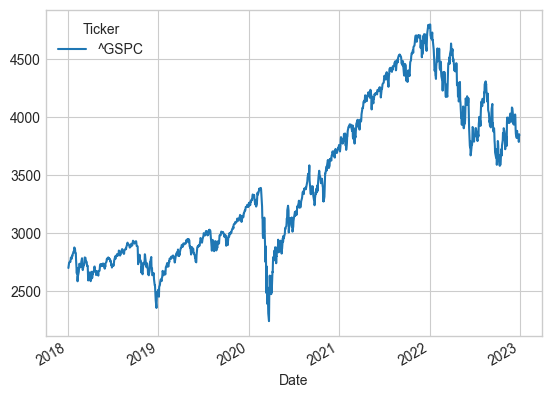

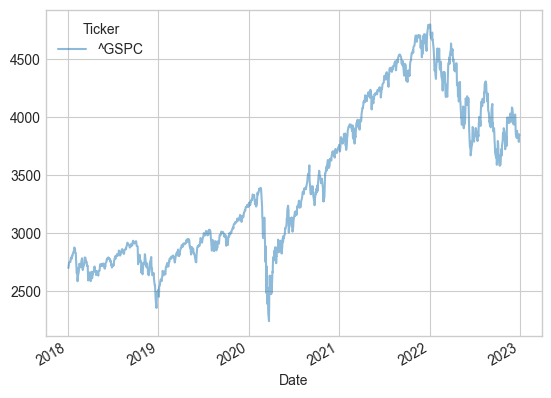

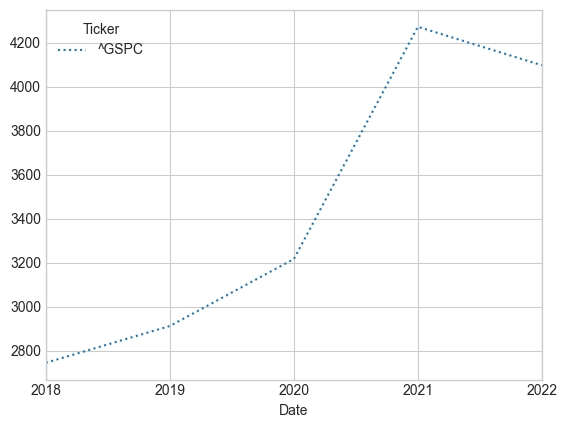

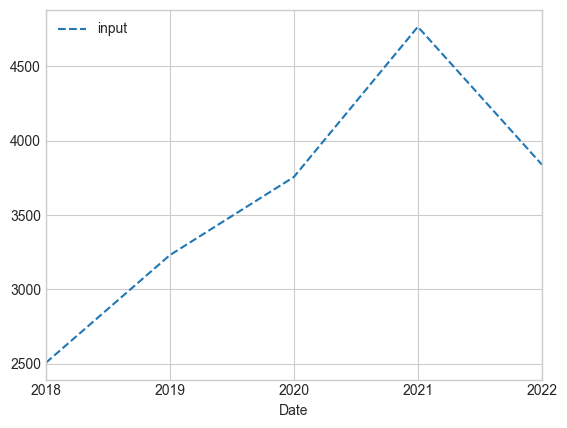

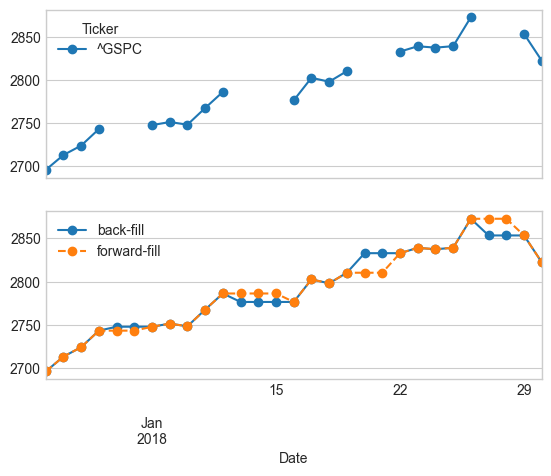

In [30]:
fig, ax = plt.subplots(2, sharex=True)
data = sp500.iloc[:20]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);
plt.show();

Because the S&P 500 data only exists for business days, the top panel has gaps representing NA values.
The bottom panel shows the differences between two strategies for filling the gaps: forward filling and backward filling.

### Time Shifts

Another common time series–specific operation is shifting of data in time.
For this, Pandas provides the `shift` method, which can be used to shift data by a given number of entries.
With time series data sampled at a regular frequency, this can give us a way to explore trends over time.

For example, here we resample the data to daily values, and shift by 364 to compute the 1-year return on investment for the S&P 500 over time (see the following figure):

In [31]:
sp500 = sp500.asfreq('D', method='pad')

ROI = 100 * (sp500.shift(-365) - sp500) / sp500
ROI.plot()
plt.ylabel('% Return on Investment after 1 year');

The worst one-year return was around March 2019, with the coronavirus-related market crash exactly a year later. As you might expect, the best one-year return was to be found in March 2020, for those with enough foresight or luck to buy low.

### Rolling Windows

Calculating rolling statistics is a third type of time series–specific operation implemented by Pandas.
This can be accomplished via the `rolling` attribute of `Series` and `DataFrame` objects, which returns a view similar to what we saw with the `groupby` operation (see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb)).
This rolling view makes available a number of aggregation operations by default.



For example, we can look at the one-year centered rolling mean and standard deviation of the  stock prices (see the following figure):

C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\3193489742.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2018-01-01", end="2022-12-31")
[*********************100%***********************]  1 of 1 completed


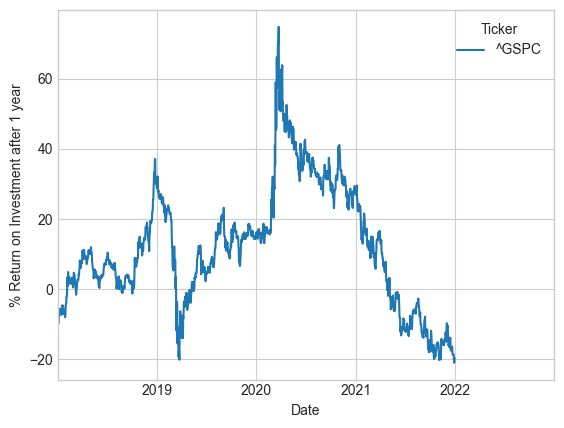

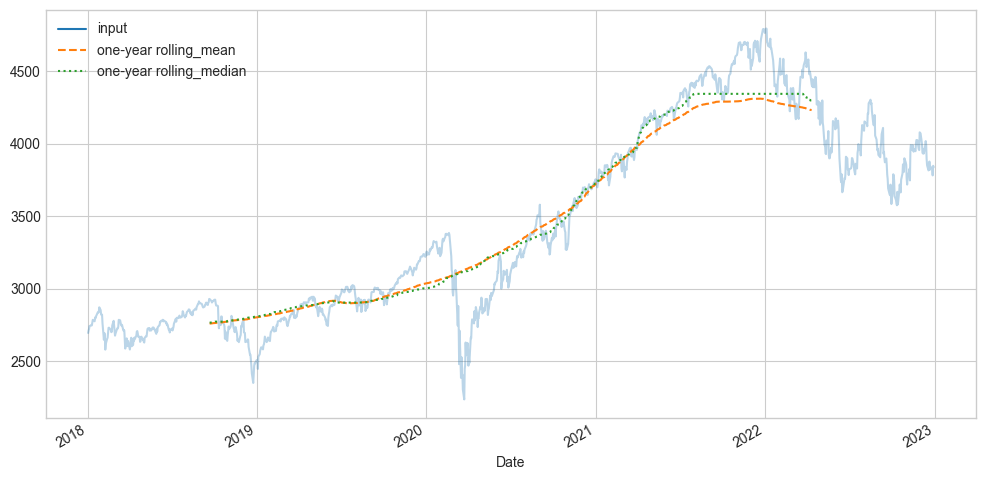

In [38]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# 1. Download S&P 500 data
sp500 = yf.download("^GSPC", start="2018-01-01", end="2022-12-31")

# 2. Extract the closing prices
close = sp500["Close"]

# 3. Rolling object (365-day centered window)
rolling = close.rolling(window=365, center=True)

# 4. Build DataFrame by concatenating Series
data = pd.concat(
    [close, rolling.mean(), rolling.median()],
    axis=1
)
data.columns = ["input", "one-year rolling_mean", "one-year rolling_median"]

# 5. Plot
ax = data.plot(style=["-", "--", ":"], figsize=(12,6))
ax.lines[0].set_alpha(0.3)
plt.show()



As with `groupby` operations, the `aggregate` and `apply` methods can be used for custom rolling computations.

## Where to Learn More

This chapter has provided only a brief summary of some of the most essential features of time series tools provided by Pandas; for a more complete discussion, you can refer to the ["Time Series/Date Functionality" section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) of the Pandas online documentation.

Another excellent resource is the book [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781098104023/) by Wes McKinney (O'Reilly).
It is an invaluable resource on the use of Pandas.
In particular, this book emphasizes time series tools in the context of business and finance, and focuses much more on particular details of business calendars, time zones, and related topics.

As always, you can also use the IPython help functionality to explore and try out further options available to the functions and methods discussed here. I find this often is the best way to learn a new Python tool.

## Example: Visualizing Seattle Bicycle Counts

As a more involved example of working with time series data, let's take a look at bicycle counts on Seattle's [Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965).
This data comes from an automated bicycle counter installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.
The hourly bicycle counts can be downloaded from [http://data.seattle.gov](http://data.seattle.gov); the Fremont Bridge Bicycle Counter dataset is available under the Transportation category.

The CSV used for this book can be downloaded as follows:

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data directly from URL
url = "https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD"
data = pd.read_csv(url, index_col='Date', parse_dates=True)



C:\Users\nicek\AppData\Local\Temp\ipykernel_13392\858077506.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(url, index_col='Date', parse_dates=True)


In [39]:
# url = ('https://raw.githubusercontent.com/jakevdp/'
#        'bicycle-data/main/FremontBridge.csv')
# !curl -O {url}

Once this dataset is downloaded, we can use Pandas to read the CSV output into a `DataFrame`.
We will specify that we want the `Date` column as an index, and we want these dates to be automatically parsed:

In [44]:
data.head()

,"Fremont Bridge Sidewalks, south of N 34th St Total","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk"
Date,,,
2012-10-02 13:00:00,55.0,7.0,48.0
2012-10-02 14:00:00,130.0,55.0,75.0
2012-10-02 15:00:00,152.0,81.0,71.0
2012-10-02 16:00:00,278.0,167.0,111.0
2012-10-02 17:00:00,563.0,393.0,170.0


For convenience, we'll shorten the column names:

In [45]:
data.columns = ['Total', 'East', 'West']

Now let's take a look at the summary statistics for this data:

In [46]:
data.dropna().describe()

,Total,East,West
count,111908.000000,111908.000000,111908.000000
mean,106.552043,45.422803,61.129240
std,131.828247,59.025699,82.423448
min,0.000000,0.000000,0.000000
25%,13.000000,5.000000,7.000000
50%,60.000000,26.000000,33.000000
75%,146.000000,63.000000,81.000000
max,1097.000000,667.000000,850.000000


### Visualizing the Data

We can gain some insight into the dataset by visualizing it.
Let's start by plotting the raw data (see the following figure):

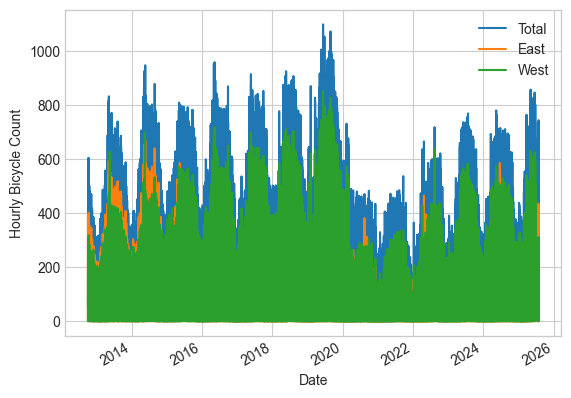

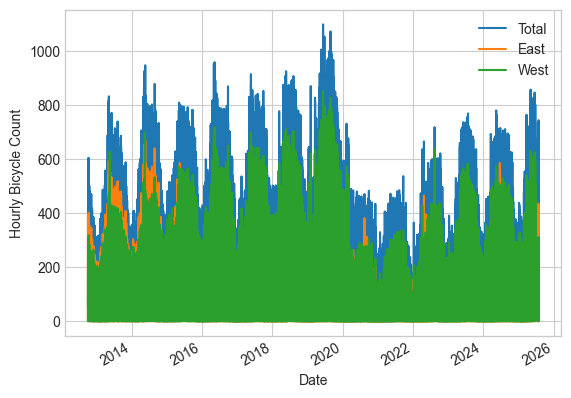

In [48]:
data.plot()
plt.ylabel('Hourly Bicycle Count');
plt.show();

The ~150,000 hourly samples are far too dense for us to make much sense of.
We can gain more insight by resampling the data to a coarser grid.
Let's resample by week (see the following figure):

In [49]:
weekly = data.resample('W').sum()
weekly.plot(style=['-', ':', '--'])
plt.ylabel('Weekly bicycle count');

This reveals some trends: as you might expect, people bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week (likely dependent on weather; see [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), where we explore this further). Further, the effect of the COVID-19 pandemic on commuting patterns is quite clear, starting in early 2020.

Another option that comes in handy for aggregating the data is to use a rolling mean, utilizing the `pd.rolling_mean` function.
Here we'll examine the 30-day rolling mean of our data, making sure to center the window (see the following figure):

In [50]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=['-', ':', '--'])
plt.ylabel('mean hourly count');

The jaggedness of the result is due to the hard cutoff of the window.
We can get a smoother version of a rolling mean using a window function—for example, a Gaussian window, as shown in the following figure.
The following code specifies both the width of the window (here, 50 days) and the width of the Gaussian window (here, 10 days):

In [51]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=['-', ':', '--']);

### Digging into the Data

While these smoothed data views are useful to get an idea of the general trend in the data, they hide much of the structure.
For example, we might want to look at the average traffic as a function of the time of day.
We can do this using the `groupby` functionality discussed in [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) (see the following figure):

In [52]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', ':', '--']);

The hourly traffic is a strongly bimodal sequence, with peaks around 8:00 a.m. and 5:00 p.m.
This is likely evidence of a strong component of commuter traffic crossing the bridge.
There is a directional component as well: according to the data, the east sidewalk is used more during the a.m. commute, and the west sidewalk is used more during the p.m. commute.

We also might be curious about how things change based on the day of the week. Again, we can do this with a simple `groupby` (see the following figure):

In [53]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', ':', '--']);

This shows a strong distinction between weekday and weekend totals, with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound `groupby` and look at the hourly trends on weekdays versus weekends.
We'll start by grouping by flags marking the weekend and the time of day:

In [54]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

Now we'll use some of the Matplotlib tools that will be described in [Multiple Subplots](04.08-Multiple-Subplots.ipynb) to plot two panels side by side, as shown in the following figure:

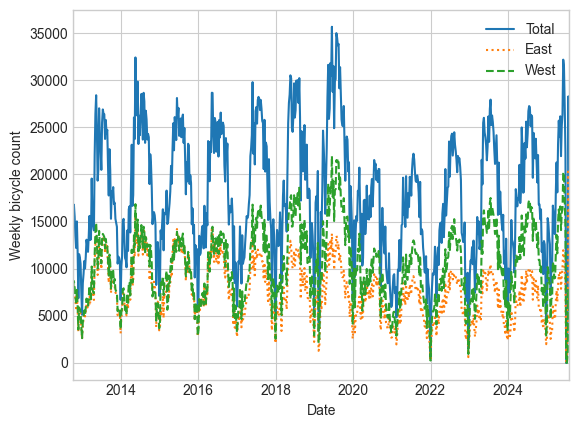

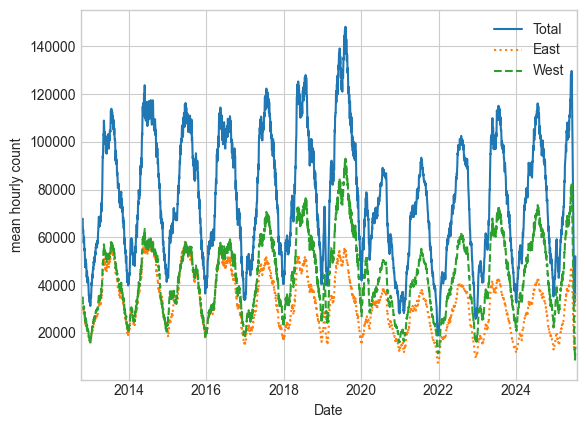

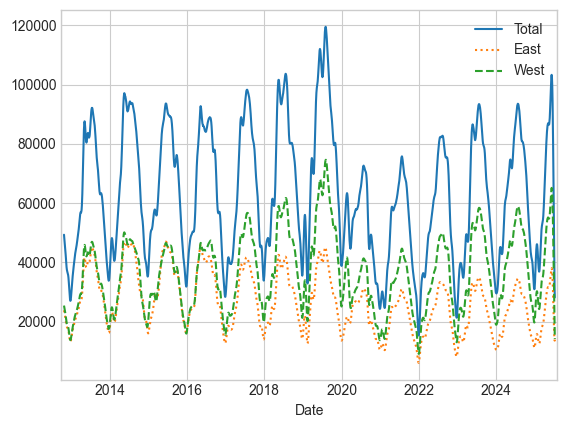

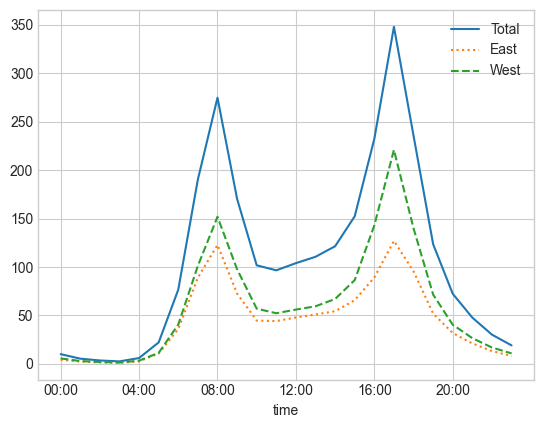

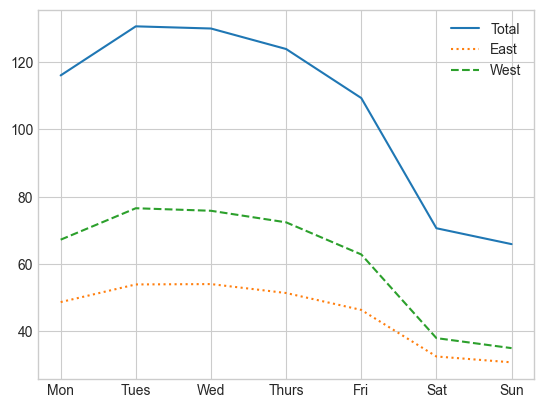

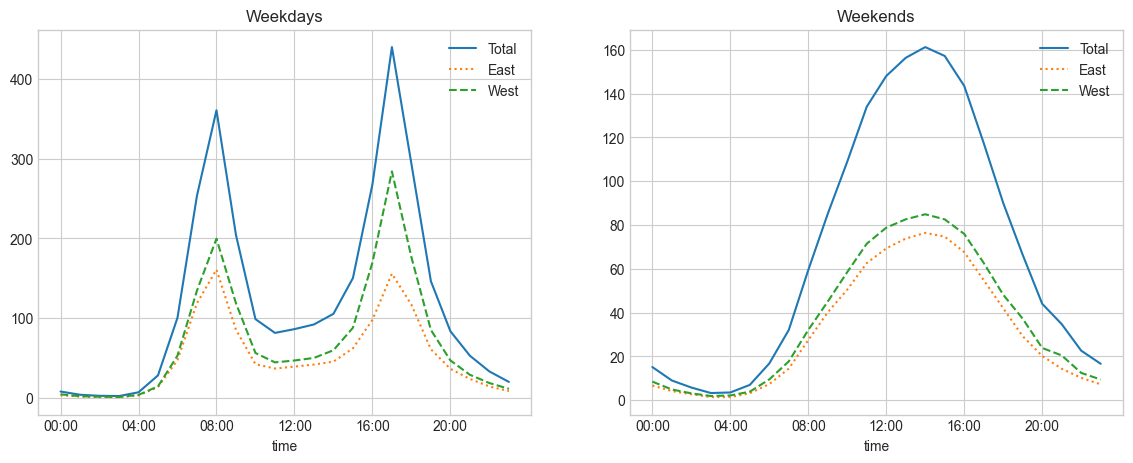

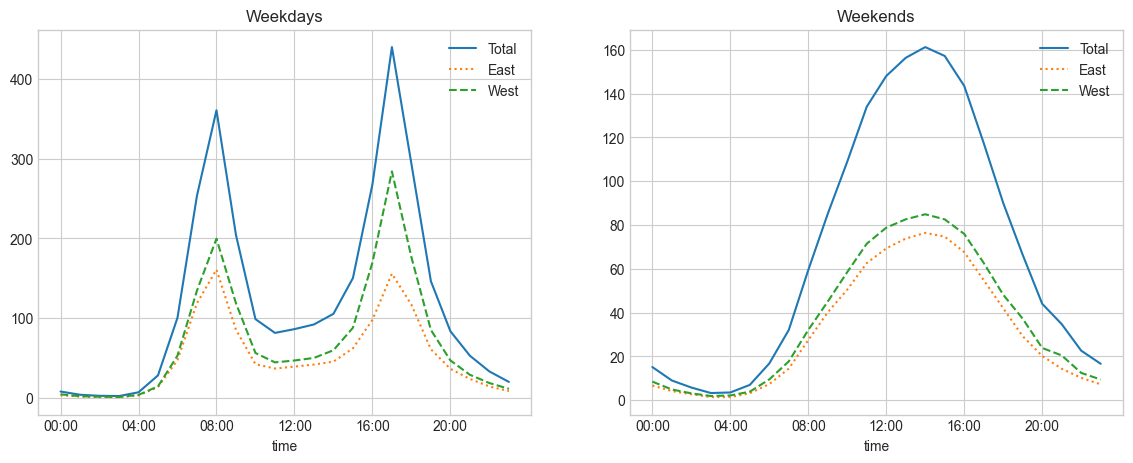

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                            xticks=hourly_ticks, style=['-', ':', '--'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                            xticks=hourly_ticks, style=['-', ':', '--']);
plt.show();

The result shows a bimodal commuting pattern during the work week, and a unimodal recreational pattern during the weekends.
It might be interesting to dig through this data in more detail and examine the effects of weather, temperature, time of year, and other factors on people's commuting patterns; for further discussion, see my blog post ["Is Seattle Really Seeing an Uptick in Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), which uses a subset of this data.
We will also revisit this dataset in the context of modeling in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).